<a href="https://colab.research.google.com/github/ManuelGehl/IMPRS-Introduction-to-Neural-Networks-2023/blob/main/Malaria_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook we are going to build a binary classification model to predict if a cell is infected with malaria.

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub

In [12]:
# Prepare the dataset

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
tf.random.set_seed(42)

# Load full dataset and split it into 70%:30% train and test dataset
(validation_dataset, train_dataset, test_dataset), info = tfds.load(
    'malaria',
    split=["train[:10%]","train[10%:70%]", "train[70%:100%]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    )

# Take 10% of the train dataset for baseline models
shuffled_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
train_dataset_10 = shuffled_dataset.take(round(len(train_dataset) / 10))

# Check distribution of different datasets
num_train = len(train_dataset)
num_train_1 = len(train_dataset_10)
num_test = len(test_dataset)
num_validation = len(validation_dataset)
print(f"Samples in train_dataset: {num_train} \nSamples in train_dataset_10: {num_train_1} \nSamples in test_dataset: {num_test} \nSamples in validation_dataset: {num_validation} \n \nSamples overall: {num_train+num_test+num_validation}\n")
info

Samples in train_dataset: 16535 
Samples in train_dataset_10: 1654 
Samples in test_dataset: 8267 
Samples in validation_dataset: 2756 
 
Samples overall: 27558



tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [13]:
# Check if classes are balanced in train_dataset
counter = []

for image, label in train_dataset:
  counter.append(label.numpy())

print(f"Number of parazited images: {counter.count(0)} \nNumber of uninfected images: {counter.count(1)}")

Number of parazited images: 8289 
Number of uninfected images: 8246


In [14]:
# Check if classes are balanced in train_dataset_10
counter = []

for image, label in train_dataset_10:
  counter.append(label.numpy())

print(f"Number of parazited images: {counter.count(0)} \nNumber of uninfected images: {counter.count(1)}")

Number of parazited images: 831 
Number of uninfected images: 823


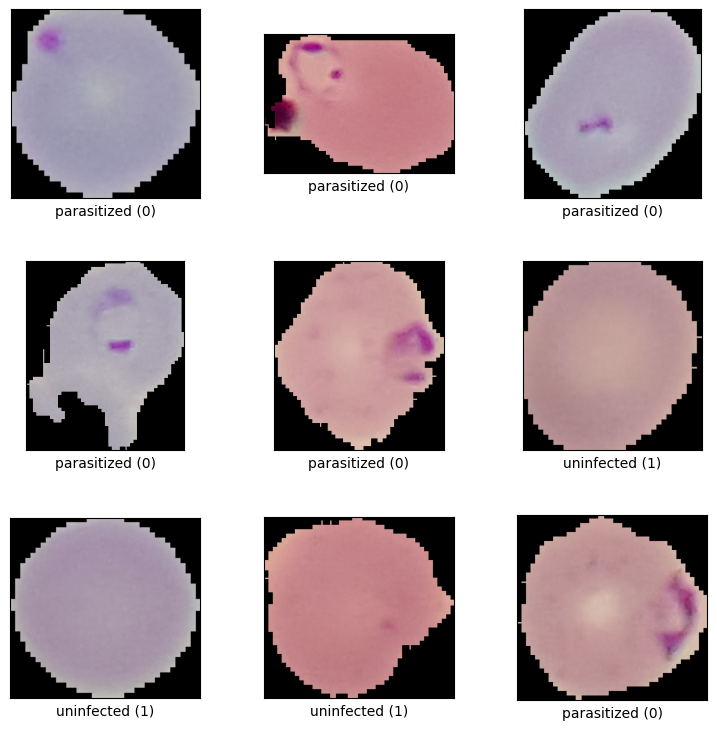

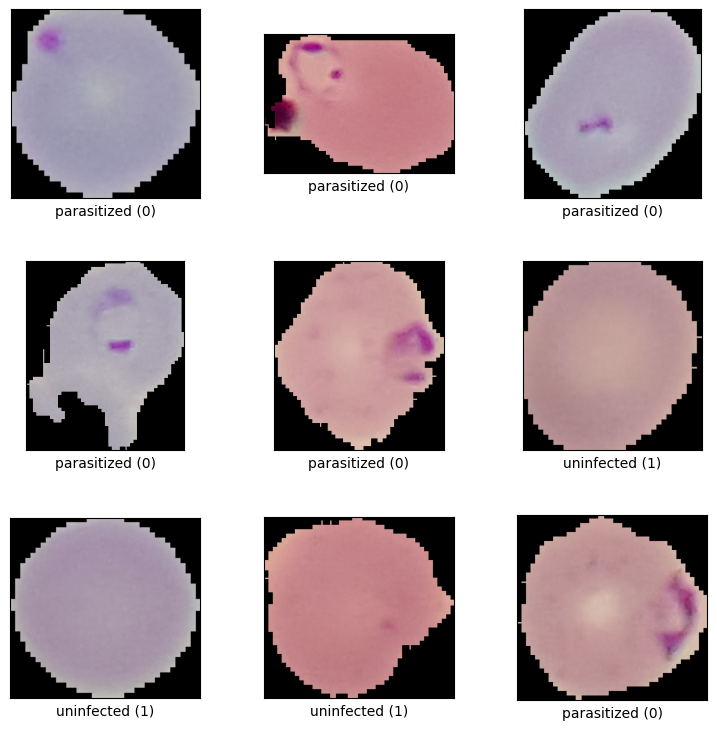

In [15]:
# Visualize some examples of the dataset
tfds.visualization.show_examples(train_dataset, info)

In [16]:
# Check image shape of some images
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (103, 103, 3)


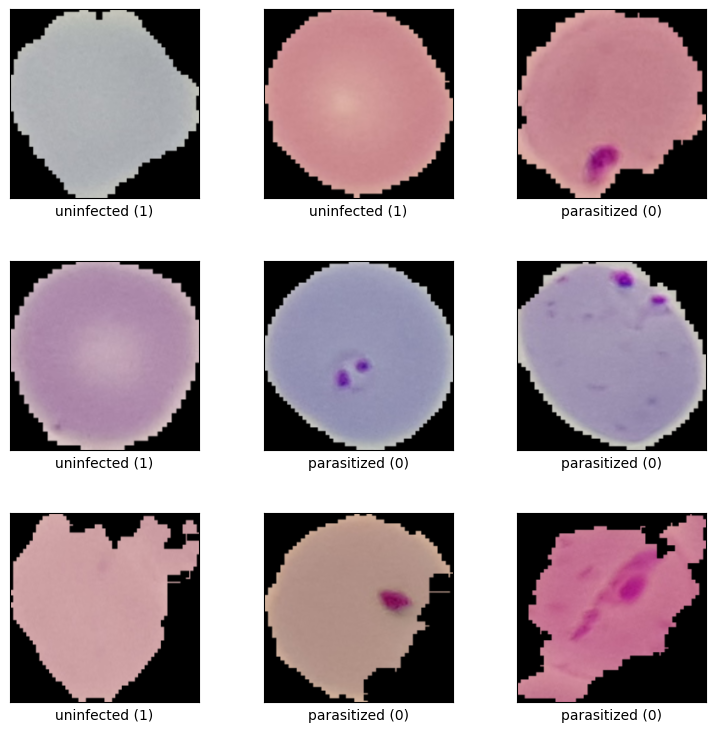

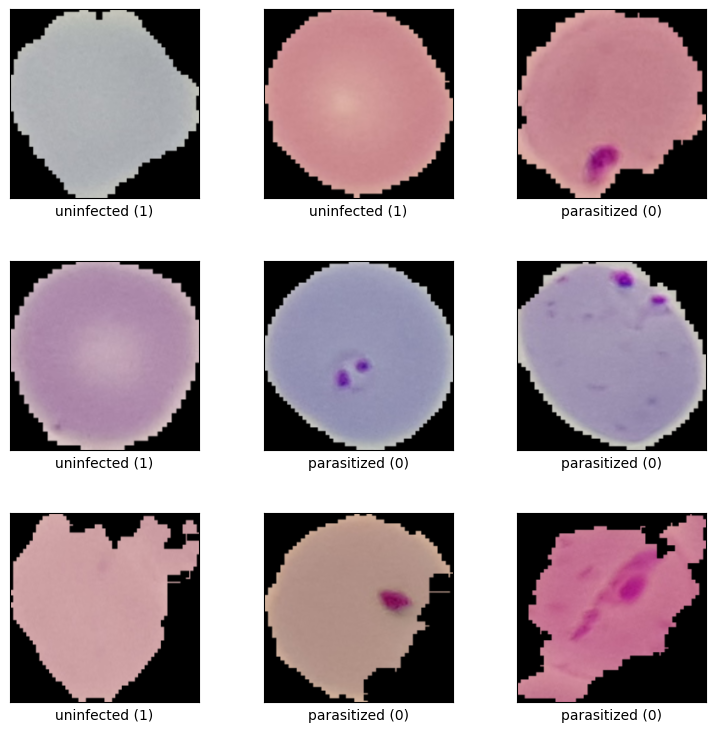

In [17]:
# Resize images, rescale them, and batch them

def transform_image(image, label):
  resized_image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  transformed_image = tf.divide(resized_image, 255.0)
  return transformed_image, label

# Apply the resize function to the dataset
train_dataset = train_dataset.map(transform_image)
train_dataset_10 = train_dataset_10.map(transform_image)
test_dataset = test_dataset.map(transform_image)
validation_dataset = validation_dataset.map(transform_image)

tfds.visualization.show_examples(train_dataset, info)

In [18]:
# Check image shape of some images
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (224, 224, 3)


In [19]:
# Batch dataset
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset_10 = train_dataset_10.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [20]:
# Check image tensor dimensions
sample_image = next(iter(train_dataset))[0]
print(f"Sample image shape: {sample_image.shape}")

Sample image shape: (32, 224, 224, 3)


In [21]:
# Before we start modelling, let's create a lab-book to track the different experiments
lab_book = {}

# Model 1:
- Flatten layer to convert image tensor (224, 224, 3) into 1D tensor
- Hidden layer with 10 neurons (activation = ReLU)
- Output layer with 1 neuron (activation = sigmoid)

In [22]:
# Name your model
name = "Dense model"

# Build our model
model_1 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT,IMG_WIDTH,3)),
                            layers.Flatten(),
                            layers.Dense(10, activation="relu"),
                            layers.Dense(1, activation="sigmoid")
                           ])

model_1.summary()

#  Compile the model
model_1.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"]
                )

# Fit the model
history_1 = model_1.fit(train_dataset_10, validation_data = validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_2 (Dense)             (None, 10)                1505290   
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,505,301
Trainable params: 1,505,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 17s 74ms/step - loss: 3.3092 - accuracy: 0.4746 - val_loss: 0.6931 - val_accuracy: 0.4906
Epoch 2/5
52/52 [==============================] - 12s 75ms/step - loss: 0.7294 - accuracy: 0.4909 - val_loss: 0.6932 - val_accuracy: 0.4906
Epoch 3/5
52/52 [=========

# Model 2:
- Conv2D layer with 3 neurons/filters
- Flatten layer
- Output layer with 1 neuron (activation = sigmoid)

In [23]:
# Name your model
name = "CNN model 1"

# Build CNN model
model_2 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                             layers.Conv2D(filters=3,
                                           kernel_size=(3,3),
                                           strides=(1,1),
                                           activation="relu"),
                             layers.Flatten(),
                             layers.Dense(1, activation="sigmoid")])

model_2.summary()

# Compile CNN model
model_2.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_2 = model_2.fit(train_dataset_10, validation_data = validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_2

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 3)       84        
                                                                 
 flatten_2 (Flatten)         (None, 147852)            0         
                                                                 
 dense_4 (Dense)             (None, 1)                 147853    
                                                                 
Total params: 147,937
Trainable params: 147,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 21s 126ms/step - loss: 1.5770 - accuracy: 0.5369 - val_loss: 0.6561 - val_accuracy: 0.6161
Epoch 2/5
52/52 [==============================] - 13s 124ms/step - loss: 0.6551 - accuracy: 0.6372 - val_loss: 0.6377 - val_accuracy: 0.6230
Epoch 3/5
52/52 [===========

In [24]:
# Define function to compare the histories of different experiments from the lab-book
def plot_history(histories:dict):
  num_histories = len(histories)
  fig, ax = plt.subplots(2,2, figsize=(10,7))
  ax[0,0].set_title("Losses")
  ax[0,1].set_title("Validation losses")
  ax[1,0].set_title("Accuracies")
  ax[1,1].set_title("Validation accuracies")
  ax[1,0].set_xlabel("Epochs")
  ax[1,1].set_xlabel("Epochs")

  for i in range (num_histories):
    keys = list(lab_book.keys())
    values = list(lab_book.values())
    ax[0,0].plot(values[i].history["loss"], label=keys[i])
    ax[0,1].plot(values[i].history["val_loss"][1:], label=keys[i])
    ax[1,0].plot(values[i].history["accuracy"], label=keys[i])
    ax[1,1].plot(values[i].history["val_accuracy"], label=keys[i])

  #ax[0,0].set_xlim(left=1)
  #ax[0,1].set_xlim(left=1)
  ax[0,0].legend()
  ax[1,0].legend()
  ax[0,1].legend()
  ax[1,1].legend()

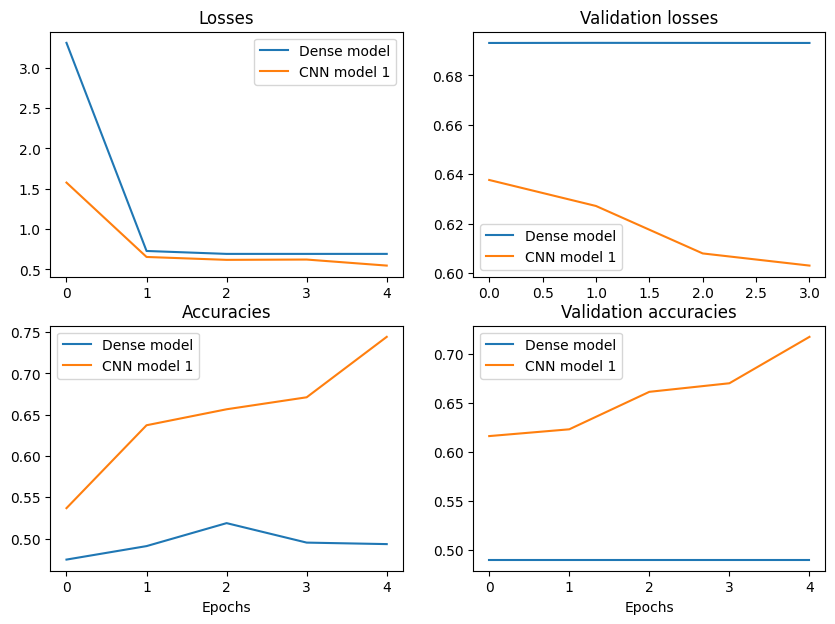

In [25]:
# Visualize learning performance of our first two models
plot_history(lab_book)

# Model 3:

In [26]:
# Name your model
name = "CNN model 2"

# Build CNN model
model_3 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           strides=(1,1),
                                           activation="relu"),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Flatten(),
                            layers.Dense(128, activation="relu"),
                            layers.Dense(64, activation="relu"),
                            layers.Dense(1, activation="sigmoid")])

model_3.summary()

# Compile CNN model
model_3.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_3 = model_3.fit(train_dataset_10, validation_data = validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_3

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_4 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

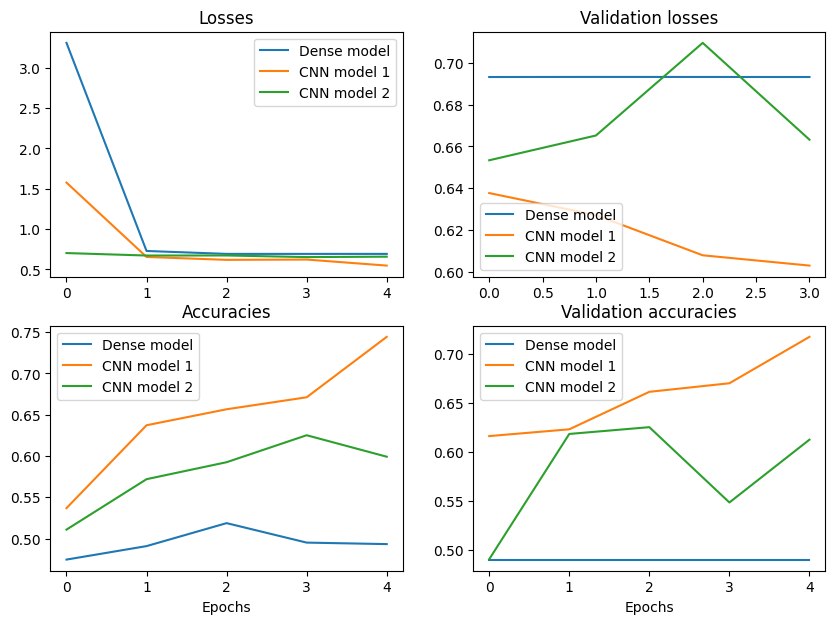

In [27]:
# Visualize learning performance of all models
plot_history(lab_book)

# Model 4:
- Feature extraction model based in EfficientNet/B0

In [28]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                         trainable=False, # freeze the underlying patterns
                                         name='feature_extraction_layer',
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)) # define the input image shape

In [29]:
# Name your model
name = "Feature extraction model 1"

# Build model
model_4 = keras.Sequential([feature_extractor_layer,
                             layers.Dense(1, activation="sigmoid")])

model_4.summary()

# Compile CNN model
model_4.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_4 = model_4.fit(train_dataset_10, validation_data = validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_4

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 dense_8 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________
Epoch 1/5
52/52 [==============================] - 33s 299ms/step - loss: 0.4504 - accuracy: 0.8108 - val_loss: 0.3304 - val_accuracy: 0.8759
Epoch 2/5
52/52 [==============================] - 16s 152ms/step - loss: 0.2988 - accuracy: 0.8912 - val_loss: 0.2711 - val_accuracy: 0.9017
Epoch 3/5
52/52 [==============================] - 15s 155ms/step - loss: 0.2579 - acc

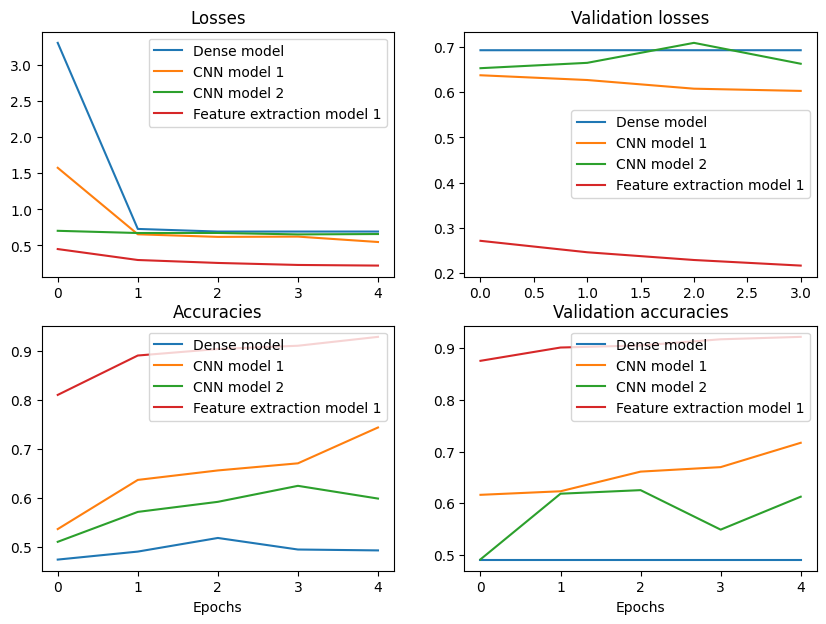

In [30]:
# Visualize learning performance of all models
plot_history(lab_book)

# Time to train our best model on 100% of the training data

In [31]:
# Let's train CNN model 2 on 100% of training data

# Name your model
name = "CNN model 2 full"

# Build CNN model
model_5 = keras.Sequential([layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           strides=(1,1),
                                           activation="relu"),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.Conv2D(filters=10,
                                           kernel_size=(3,3),
                                           activation="relu"),
                            layers.MaxPool2D(pool_size=(2,2)),
                            layers.Flatten(),
                            layers.Dense(128, activation="relu"),
                            layers.Dense(64, activation="relu"),
                            layers.Dense(1, activation="sigmoid")])

model_5.summary()

# Compile CNN model
model_5.compile(loss=keras.losses.BinaryCrossentropy(),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit CNN model
history_5 = model_5.fit(train_dataset, validation_data = validation_dataset, epochs=5)

# Write lab-book
lab_book[name] = history_5

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_6 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_8 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

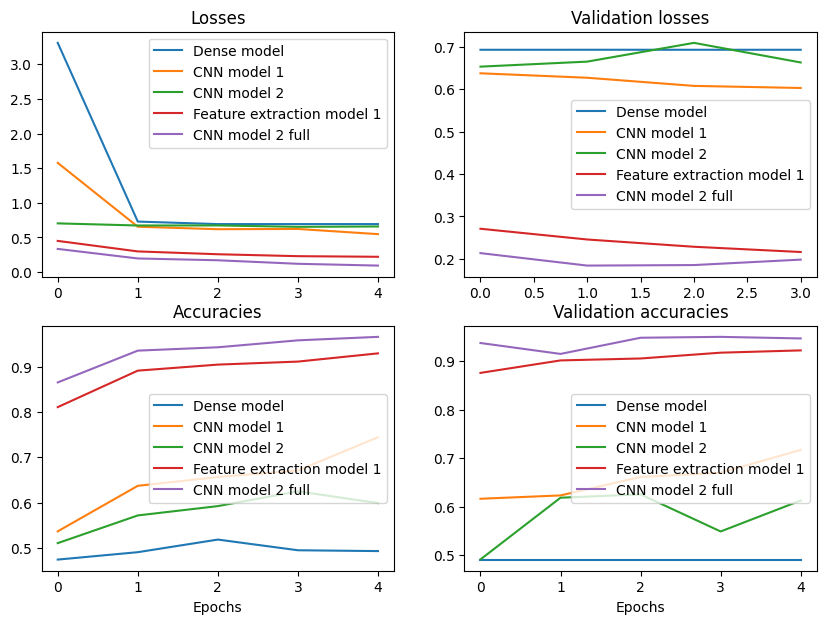

In [32]:
# Visualize learning performance of all models
plot_history(lab_book)

# Final evaluation of all models

In [33]:
# Finally, let's evaluate all our models based on the test dataset

eval = []
for i in range(1,6):
  model_name = "model_" + str(i)
  model_name = globals()[model_name]
  eval.append(model_name.evaluate(test_dataset))

# Transform into a dataframe
results = pd.DataFrame(eval).round(decimals=2)
results

259/259 [==============================] - 11s 41ms/step - loss: 0.2020 - accuracy: 0.9463


,0,1
0,0.69,0.50
1,0.60,0.72
2,0.66,0.61
3,0.21,0.92
4,0.20,0.95


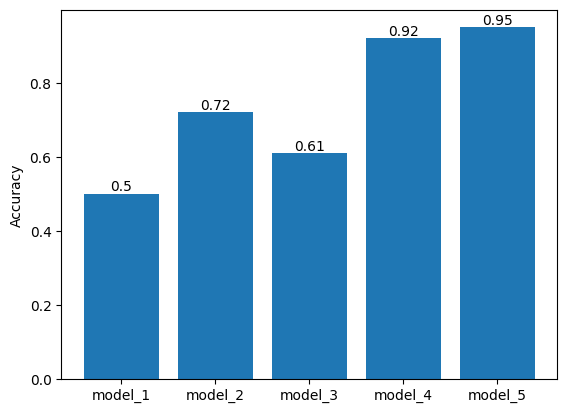

In [35]:
# Plot a bar plot with accuracy scores
fig, ax = plt.subplots()
p = ax.bar(x=["model_" + str(i) for i in range(1,6)],height=results[1])
ax.set_ylabel("Accuracy")
ax.bar_label(p);